# Packages

In [2]:
import numpy as np
import numpy.random as npr
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm
from keras.layers import Input, Dense, Concatenate, SimpleRNNCell, StackedRNNCells, RNN, LSTMCell
from keras.models import Model
from keras import backend as kb
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
plt.style.use('ggplot')
%run Fourier.ipynb # Imports some functions: Heston greeks and L(t,v)
%run Neural_Networks.ipynb # Imports Neural Network
%run Simulation.ipynb # Imports the function to simulate from the Heston model

### Set the seed for reproducible results

In [5]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Parameters 

In [67]:
# Model parameters 
S0 = 100
K = 100
V0 = 0.2**2
mu = 0.1
sigma = 0.3
kappa = 1
theta = 0.2**2
rho = -0.7
r = 0.05
T = 30/365

# Proportional transaction costs
prop = 0.01

# Simulation parameters
steps = 30
dt = T/steps
n_train = 100000
n_test = 10000
#simulation_method = "full truncation" # Choose either "full truncation" or "moment matching" or load data in directly


# Neural Network parameters
epochs = 10
learn_rate = 0.001
batch_size = 100
neurons = 200 # Number of neurons in hidden layers
n_hidden_layers = 4 # Number of hidden layers
n_inputs = 3 # time, logS(t) and the volatility
n_outputs = 2 # delta1 and delta2
RNN_type = "LSTM" # Choose either "simple" or "LSTM"

In [27]:
callprice = HestonFourier(spot=S0, timetoexp=T, strike=K, r=r, divyield=0, V=V0, theta=theta, kappa=kappa, sigma=sigma, rho=rho, greek=1)
print(callprice)

2.4859242733097773


In [28]:
### For RNN

time_grid = np.linspace(0,T,steps+1)

S1_train = np.load("S1_train.npy")
V_train = np.load("V_train.npy")
S2_train = np.cumsum(np.load("intV_train.npy"),axis=-1)+L(time_grid,V_train)

dS1_train = np.diff(S1_train,1,1)
dS2_train = np.diff(S2_train,1,1)

# Append the two lists alternatingly
dS_train = np.empty(shape=(n_train,2*steps))
dS_train[:,::2] = dS1_train
dS_train[:,1::2] = dS2_train
dS_train = np.reshape(dS_train,(n_train,steps,2))

# Creates training input for NN
input_train = []
time_hedge = np.reshape(time_grid[:-1],(steps,1))
for i in range(n_train):
    S1_input_train = np.reshape(np.log(S1_train[i,:-1])-np.log(S0),(steps,1))
    V_input_train = np.reshape(V_train[i,:-1]-V0,(steps,1))
    input_train.append(np.concatenate((time_hedge,S1_input_train,V_input_train),1))
input_train = tf.stack(input_train)
dS_train = tf.stack(dS_train)

In [29]:
def value_pf(y_true,y_pred):
    S1 = S0
    S2 = L(0,V0)
    dS1 = y_true[:,:,0]
    dS2 = y_true[:,:,1]
    delta1 = y_pred[:,:,0]
    delta2 = y_pred[:,:,1]
    Vpf = callprice 
    B = Vpf - delta1[:,0]*S1*(1+prop)-delta2[:,0]*S2*(1+prop)
    for i in range(1,steps):
        S1 += dS1[:,i-1]
        S2 += dS2[:,i-1]
        Vpf = delta1[:,i-1]*S1+delta2[:,i-1]*S2+B*kb.exp(r*dt)
        tc = prop*S1*kb.abs(delta1[:,i]-delta1[:,i-1]) + prop*S2*kb.abs(delta2[:,i]-delta2[:,i-1])
        B = Vpf - delta1[:,i]*S1 - delta2[:,i]*S2 - tc
    S1 += dS1[:,-1]
    S2 += dS2[:,-1]
    Vpf = delta1[:,-1]*S1+delta2[:,-1]*S2+B*kb.exp(r*dt)
    return Vpf
        
def loss_call(y_true,y_pred):
    return (value_pf(y_true,y_pred) - kb.maximum(S0 + kb.sum(y_true[:,:,0],axis=-1) - K,0.))**2

In [70]:
model = Recurrent_NN('linear',n_inputs,n_outputs,loss_call, learn_rate,neurons,n_hidden_layers,RNN_type)

In [9]:
#model.summary()

In [71]:
model.fit(input_train,dS_train,batch_size=batch_size,epochs=epochs)

Epoch 1/10
1000/1000 [==============================] - 743s 731ms/step - loss: 2.3124
Epoch 2/10
1000/1000 [==============================] - 733s 733ms/step - loss: 1.6850
Epoch 3/10
1000/1000 [==============================] - 724s 724ms/step - loss: 1.6363
Epoch 4/10
1000/1000 [==============================] - 731s 731ms/step - loss: 1.5961
Epoch 5/10
1000/1000 [==============================] - 725s 725ms/step - loss: 1.5723
Epoch 6/10
1000/1000 [==============================] - 727s 727ms/step - loss: 1.5511
Epoch 7/10
1000/1000 [==============================] - 727s 727ms/step - loss: 1.5455
Epoch 8/10
1000/1000 [==============================] - 750s 750ms/step - loss: 1.5373
Epoch 9/10
1000/1000 [==============================] - 788s 788ms/step - loss: 1.5307
Epoch 10/10
1000/1000 [==============================] - 805s 805ms/step - loss: 1.5259


In [4]:
#model.save('Heston LSTM TC')
#model = tf.keras.models.load_model('Heston RNN TC', compile=False)

# Test

In [73]:
S1_test = np.load('S1_test.npy')
S2_test = np.load('S2_test.npy')
V_test = np.load('V_test.npy')

In [74]:
# For RNN
dS1_test = np.diff(S1_test,1,1)
dS2_test = np.diff(S2_test,1,1)

# Append the two lists alternatingly
dS_test = np.empty(shape=(n_test,2*steps))
dS_test[:,::2] = dS1_test
dS_test[:,1::2] = dS2_test
dS_test = np.reshape(dS_test, (n_test,steps,2))
dS_train = tf.stack(dS_train)

# Creates test input for NN
input_test = []

for i in range(n_test):
    S1_input_test = np.reshape(np.log(S1_test[i,:-1])-np.log(S0),(steps,1))
    V_input_test = np.reshape(V_test[i,:-1]-V0,(steps,1))
    input_test.append(np.concatenate((time_hedge,S1_input_test,V_input_test),1))
input_test = tf.stack(input_test)

In [75]:
delta_NN_test = model.predict(input_test)
delta1_NN_test = delta_NN_test[:,:,0]
delta2_NN_test = delta_NN_test[:,:,1]

Vpf_NN = callprice
B = Vpf_NN - delta1_NN_test[:,0]*S1_test[:,0]*(1+prop)-delta2_NN_test[:,0]*S2_test[:,0]*(1+prop)
for i in range(1,steps):
    Vpf_NN = delta1_NN_test[:,i-1]*S1_test[:,i]+delta2_NN_test[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    tc1 = np.abs(delta1_NN_test[:,i]-delta1_NN_test[:,i-1])*S1_test[:,i]*prop
    tc2 = np.abs(delta2_NN_test[:,i]-delta2_NN_test[:,i-1])*S2_test[:,i]*prop
    B = Vpf_NN - delta1_NN_test[:,i]*S1_test[:,i]-delta2_NN_test[:,i]*S2_test[:,i]-tc1-tc2
Vpf_NN = delta1_NN_test[:,-1]*S1_test[:,-1]+delta2_NN_test[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)
Vpf_NN = np.array(Vpf_NN)

In [76]:
S1_grid2 = np.linspace(np.amin(S1_test[:,-1]),np.amax(S1_test[:,-1]),num=1000)
value_call_grid = np.maximum(S1_grid2-K,0)
value_call_true = np.maximum(S1_test[:,-1]-K,0)

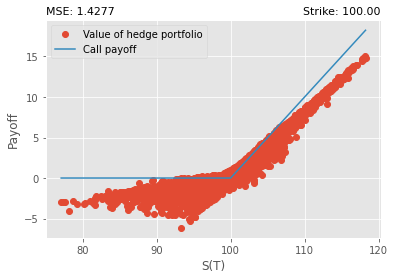

In [77]:
PnL_NN = Vpf_NN - value_call_true
MSE_NN = np.sum(PnL_NN**2)/n_test
hedge_NN    = plt.plot(S1_test[:,-1],Vpf_NN, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_NN, loc='left', fontsize=11)
plt.legend(loc='upper left')

plt.show()
#plt.savefig("HestonHedge_NN_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

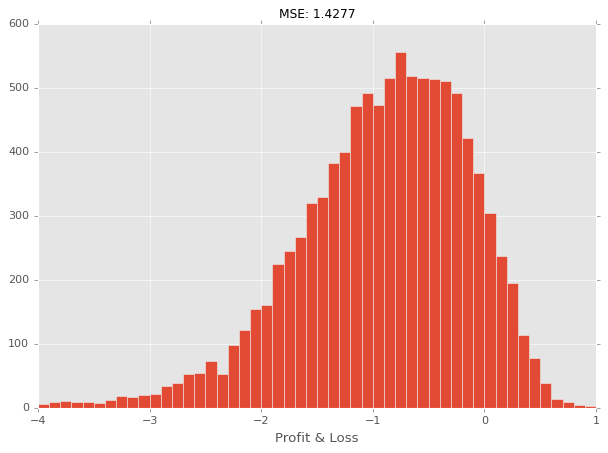

In [81]:
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_NN,bins=50, range=(-4,1))
    plt.title(r'MSE: %1.4f' % MSE_NN, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,600)
plt.show()
#plt.savefig("HestonPnL_NN_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

# Comparison to hedging using model deltas

In [3]:
# Either load deltas or calculate them (takes time)
delta1_m_test = np.load('delta1_m_exact.npy')
delta2_m_test = np.load('delta2_m_exact.npy')

#delta1_m_test = np.empty([n_test,steps])
#delta2_m_test = np.empty([n_test,steps])

#for i in range(steps):
#    delta1_m_test[:,i] = vdelta1(S1_test[:,i],V_test[:,i],i*dt)
#    delta2_m_test[:,i] = vdelta2(S1_test[:,i],V_test[:,i],i*dt)
#    counter += 1
#    np.save('delta1_m_test',delta1_m_test)
#    np.save('delta2_m_test',delta2_m_test)
#    np.save('counter', counter)
#    clear_output()
#    print(str(i+1)+' of '+str(steps)+' completed')
#print('Finished.')


In [43]:
Vpf_m = callprice
B = Vpf_m - delta1_m_test[:,0]*S1_test[:,0]*(1+prop)-delta2_m_test[:,0]*S2_test[:,0]*(1+prop)
for i in range(1,steps):
    Vpf_m = delta1_m_test[:,i-1]*S1_test[:,i]+delta2_m_test[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    tc1 = np.abs(delta1_m_test[:,i]-delta1_m_test[:,i-1])*S1_test[:,i]*prop
    tc2 = np.abs(delta2_m_test[:,i]-delta2_m_test[:,i-1])*S2_test[:,i]*prop
    B = Vpf_m - delta1_m_test[:,i]*S1_test[:,i]-delta2_m_test[:,i]*S2_test[:,i] -tc1 -tc2
Vpf_m = delta1_m_test[:,-1]*S1_test[:,-1]+delta2_m_test[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)

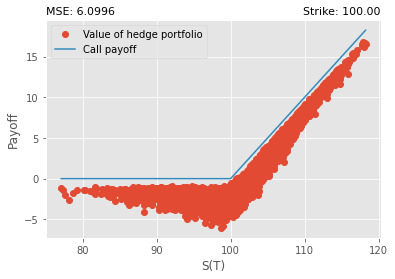

In [44]:
PnL_m = Vpf_m - value_call_true
MSE_m = np.sum(PnL_m**2)/n_test
hedge_m = plt.plot(S1_test[:,-1],Vpf_m, 'o', label="Value of hedge portfolio")
line_call = plt.plot(S1_grid2,value_call_grid, label="Call payoff")
plt.xlabel("S(T)")
plt.ylabel("Payoff")
plt.title(r'Strike: %1.2f' % K, loc='right', fontsize=11)
plt.title(r'MSE: %1.4f' % MSE_m, loc='left', fontsize=11)
plt.legend()

plt.show()
#plt.savefig("HestonHedge_m_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

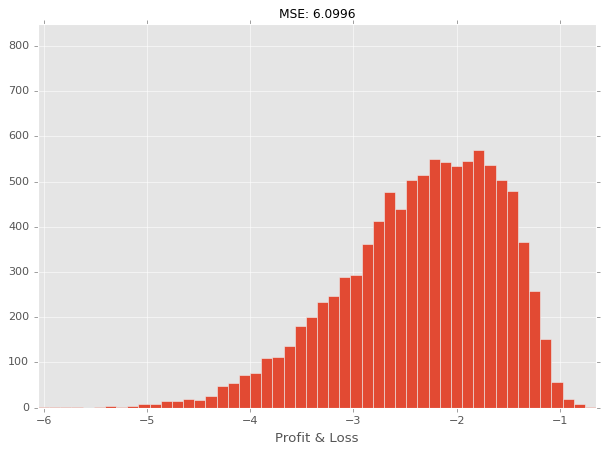

In [45]:
PnL_m = np.array(PnL_m)
with plt.style.context(['classic', 'ggplot']):
    plt.figure(figsize=(9,6))
    plt.hist(PnL_m, bins=50)
    plt.title(r'MSE: %1.4f' % MSE_m, loc='center', fontsize=11)
    plt.xlabel("Profit & Loss")
    plt.ylim(0,850)
plt.show()
#plt.savefig("HestonPnL_m_4hl200n10e1kpaths.png", dpi=500,bbox_inches="tight")

In [96]:
model_FF = tf.keras.models.load_model('Heston simple TC', compile=False)

In [87]:
# Creates test input for NN
input_FF = []

for i in range(steps):
    time_rep = np.repeat(time_grid[i],n_test)
    time_rep = np.reshape(time_rep,(n_test,1))
    S1_input_test = np.reshape(np.log(S1_test[:, i])-np.log(S0),(n_test,1))
    V_input_test = np.reshape(V_test[:,i]-V0,(n_test,1))
    input_FF.append(np.concatenate((time_rep,S1_input_test,V_input_test),1))

In [88]:
delta_FF_test = model_FF.predict(input_FF)
delta1_FF_test = delta_FF_test[:,::2]
delta2_FF_test = delta_FF_test[:,1::2]

Vpf_FF = callprice
B = Vpf_FF - delta1_FF_test[:,0]*S1_test[:,0]*(1+prop)-delta2_FF_test[:,0]*S2_test[:,0]*(1+prop)
for i in range(1,steps):
    Vpf_FF = delta1_FF_test[:,i-1]*S1_test[:,i]+delta2_FF_test[:,i-1]*S2_test[:,i]+B*np.exp(r*dt)
    tc1 = np.abs(delta1_FF_test[:,i]-delta1_FF_test[:,i-1])*S1_test[:,i]*prop
    tc2 = np.abs(delta2_FF_test[:,i]-delta2_FF_test[:,i-1])*S2_test[:,i]*prop
    B = Vpf_FF - delta1_FF_test[:,i]*S1_test[:,i]-delta2_FF_test[:,i]*S2_test[:,i]-tc1-tc2
Vpf_FF = delta1_FF_test[:,-1]*S1_test[:,-1]+delta2_FF_test[:,-1]*S2_test[:,-1]+B*np.exp(r*dt)
Vpf_FF = np.array(Vpf_FF)

In [89]:
PnL_FF = Vpf_FF - value_call_true
MSE_FF = np.sum(PnL_FF**2)/n_test

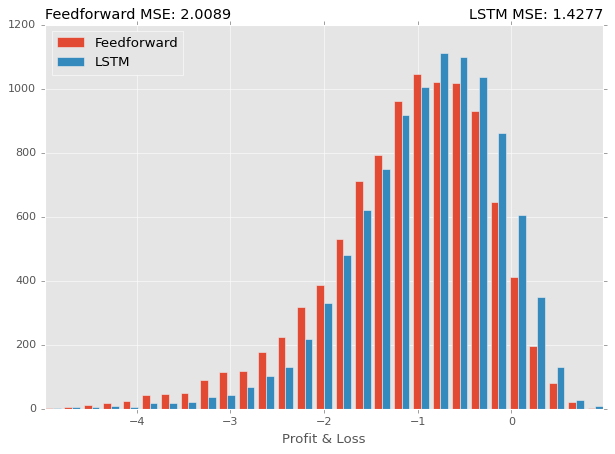

In [114]:
with plt.style.context(['classic','ggplot']):
    plt.figure(figsize=(9,6))
    bins = np.linspace(-5, 1, 30)
    plt.hist([PnL_FF, PnL_NN], bins, label=['Feedforward', 'LSTM'])
    plt.legend(loc='upper left')
    plt.xlabel("Profit & Loss")
    plt.title(r'Feedforward MSE: %1.4f' % MSE_FF, loc='left', fontsize=13)
    plt.title(r'LSTM MSE: %1.4f' % MSE_NN, loc='right', fontsize=13)
    plt.ylim(0, 1200)
plt.show()
#plt.savefig('LSTM_PnL.png',dpi=500,bbox_inches="tight")